# Figure R6 (results)
### Pb budget

In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from calendar import monthrange
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import datetime as dt
import os
from itertools import compress
from constants import imin, imax, jmin, jmax, isize, jsize, \
                      land_color, path_figure

%matplotlib inline

#### Parameters:

In [2]:
# model result set:
folder_base = '/data/brogalla/run_storage/Pb-reference-202312/'

colors  = ['#bea385','#bea385','#bacbda','#bacbda','#a0a3a3','#67b1b5','#2d7073','#a06c50']

In [3]:
years = range(2002,2022)

#### Load files:

In [4]:
# Pb model configuration ANHA12 mask:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
tmask_month  = np.tile(tmask_sub, (12,1,1,1))

# ANHA12 grid mesh:
mesh       = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base   = mesh['e1t'].values[0,imin:imax,jmin:jmax]
e2t_base   = mesh['e2t'].values[0,imin:imax,jmin:jmax]
e3t        = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)
e1t        = np.tile(e1t_base, (50,1,1))
e2t        = np.tile(e2t_base, (50,1,1))
volume     = e1t*e2t*e3t
area_base  = e1t_base*e2t_base
volume_month  = np.tile(volume, (12,1,1,1))
volume_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), area_base)
volume_month_masked = np.ma.masked_where((tmask_month[:,:,:,:] < 0.1), volume_month)

Find grid cell volume and thickness at ocean floor:

In [5]:
tmask_bot = np.copy(tmask_sub)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [6]:
# Calculate the volume of the bottom grid cell
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            vol_bot[i,j] = volume[k,i,j]
        except:
            vol_bot[i,j] = np.nan
volume_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(vol_bot), vol_bot)

#### Functions:

Compare values from monthly output for dust with the forcing field that I'm applying.

In [7]:
def load_results(folder, year):
    # Functions load the dPb model simulation results, specifically the monthly averaged component contribution files
    
    dpb_riv     = np.empty((12,isize,jsize)); dpb_sed = np.empty((12,isize,jsize)); 
    dpb_atmdust = np.empty((12,isize,jsize)); dpb_atmbc = np.empty((12,isize,jsize)); 
    dpb_icedust = np.empty((12,isize,jsize)); dpb_icebc = np.empty((12,isize,jsize));
    dpb_sedice  = np.empty((12,isize,jsize)); dpb_priv = np.empty((12,isize,jsize));
    dpb_ads     = np.empty((12,50,isize,jsize));
    
    # loop over the monthly files
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_riv[i,:,:]     = file['dpbriv'].values[0,:,:]
            dpb_priv[i,:,:]    = file['ppbriv'].values[0,:,:]
            dpb_sed[i,:,:]     = file['dpbsed'].values[0,:,:]
            dpb_sedice[i,:,:]  = file['dpbsedice'].values[0,:,:]
            dpb_atmdust[i,:,:] = file['dpbatmdust'].values[0,:,:]
            dpb_atmbc[i,:,:]   = file['dpbatmbc'].values[0,:,:]
            dpb_icedust[i,:,:] = file['dpbicedust'].values[0,:,:]
            dpb_icebc[i,:,:]   = file['dpbicebc'].values[0,:,:]
            dpb_ads[i,:,:,:]   = file['dpbads'].values[0,:,:,:]

    return dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads

In [8]:
def calculate_contribution(folder, year=2002, volume_masked=volume_masked, 
                           volume_month_masked=volume_month_masked, volume_bottom=volume_bottom, 
                           area_masked = area_masked):
    # Calculate the annual contribution of the model components for the specified year
    
    # load monthly contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year)
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': 0, 'atm_bc': 0, 'ice_dust': 0, 'ice_bc': 0, 
                    'runoff'  : 0, 'part_runoff': 0, 'resus': 0, 'sed_ice': 0, 'adsorp': 0};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust']    = total_yearly['atm_dust']    + np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc']      = total_yearly['atm_bc']      + np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust']    = total_yearly['ice_dust']    + np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc']      = total_yearly['ice_bc']      + np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff']      = total_yearly['runoff']      + np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'] = total_yearly['part_runoff'] + np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus']       = total_yearly['resus']       + np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice']     = total_yearly['sed_ice']     + np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp']      = total_yearly['adsorp']      + np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
    
    # Average yearly contribution over domain: moles / m2 / year
    ave_yearly = total_yearly.copy()
    for key in ave_yearly:
        ave_yearly[key] = ave_yearly[key]/np.ma.sum(area_masked[:,:])
 
    return total_yearly, ave_yearly

In [9]:
def calculate_contribution_monthly(folder, year=2002, volume_masked=volume_masked, 
                                   volume_month_masked=volume_month_masked, volume_bottom=volume_bottom):
    # Calculate the contribution of the model components and separate by month 
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year)
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_month_masked[:,0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_month_masked[:,0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_month_masked[:,0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_month_masked[:,0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_month_masked[:,0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_month_masked[:,0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_month_masked[:,0,:,:] * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': np.zeros(12), 'atm_bc': np.zeros(12), 'ice_dust': np.zeros(12), 'ice_bc': np.zeros(12), 
                    'runoff'  : np.zeros(12), 'part_runoff': np.zeros(12), 'resus': np.zeros(12), 'sed_ice': np.zeros(12), 
                    'adsorp'  : np.zeros(12)};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust'][month-1]    = np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc'][month-1]      = np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust'][month-1]    = np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc'][month-1]      = np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff'][month-1]      = np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'][month-1] = np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus'][month-1]       = np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice'][month-1]     = np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp'][month-1]      = np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
 
    return total_yearly

In [10]:
# estimate the transport at a transect at the edge of the boundary
# Need: dPb concentration and flow volume 
# mol/L * m3 / s * 1e3 L/m3 = mol/s * 3600*24*days_in_month = mol / month (sum over year) --> mol/yr *1e-6 = Mmol/yr
def calc_transports(ts):
    # sum over transect
    fday   = np.nansum(ts*1e3*(5*3600*24), axis=(1,2)) # mol m3/L s --> mol /s by multiplying by 1e3 --> mol/5 days
    annual = np.nansum(fday, axis=(0))*1e-6  # mol/yr --> Mmol/yr
    return fday, annual

In [11]:
def date_to_datetime(datestamp):
    # Function converts a date stamp to a datetime
    date = datetime.strptime(str(datestamp),'%Y-%m-%d %H:%M:%S')        
    return date

def dates_to_datetime(datestamps):
    # Function converts multiple date stamps to datetimes
    dates=[]
    for date in datestamps:
        datestr = datetime.strptime(str(date),'%Y-%m-%d %H:%M:%S')   
        dates.append(datestr)
    
    return dates

def within_month(year, month, dt_fday, transport_fday):
    # Function 
    if month==1: 
        prev_month = 12
        prev_year  = year-1
        next_month = month+1
        next_year  = year
    elif month==12:
        prev_month = month-1
        prev_year  = year
        next_year  = year+1
        next_month = 1
    else:
        prev_month = month-1
        prev_year  = year
        next_year  = year
        next_month = month+1
        
    # append last date of previous month and first date of next month
    if year==2021 and month==12:
        dates_in_month     = dates_to_datetime(dt_fday[(dt_fday.year==year) & (dt_fday.month==month)])
        transport_in_month = transport_fday.flatten()[(dt_fday.year==year) & (dt_fday.month==month)]         
    else:
        dates_in_month     = dates_to_datetime(dt_fday[(dt_fday.year==year) & (dt_fday.month==month)]) + \
                             [date_to_datetime(dt_fday[(dt_fday.year==next_year) & (dt_fday.month==next_month)][0])] 
        transport_in_month = np.append(transport_fday.flatten()[(dt_fday.year==year) & (dt_fday.month==month)], \
                                       transport_fday.flatten()[(dt_fday.year==next_year) & (dt_fday.month==next_month)][0]) 
        
    return dates_in_month, transport_in_month

def calc_monthly_transport(year, month, dates_in_month, transport_fday):   
    # Function calculates monthly transport of dissolved Pb into the domain based on five-day averaged transport files
    
    days_in_month = monthrange(year, month)[1]
    if days_in_month == 29: days_in_month = 28 # ignore leap year    

    # Calculate monthly contribution by weighting the 5-day files depending on how much of that 5-day file falls within the month
    max_day = dates_in_month[-2].day
    monthly_transport = 0
    for d,date in enumerate(dates_in_month):
        if (date.day - 5 >= 0) & (date.day <= days_in_month) & (date.month == month):
            monthly_transport += transport_fday[d] *(5/5) # normal case
        elif (date.month == month) & (date.day - 5 < 0):
            monthly_transport += transport_fday[d] *(date.day/5) # start of month
        elif (date.month != month) & (date.day - 5 < 0):
            monthly_transport += transport_fday[d] *(days_in_month - max_day)/5 # end of month

    return monthly_transport

### Calculations:

In [12]:
# adjust masks based on where the boundary transports are calculated
# Canada Basin:
l1 = 0; l2 = 2167-imin; 
r1 = 0; r2 = 777-jmin;
# Hudson Boundary
l3 = 0;  l4 = 1473-imin;
r3 = 0;  r4 = 303-jmin;
# Labrador Sea
l5 = 0; l6 = 1152-imin;
r5 = 446-jmin; r6 = 672-jmin;

# adjust masks:
ind_array = np.zeros(volume_month_masked.shape)
ind_array[:,:,l1:l2,r1:r2] = 1 # include area within boundaries
ind_array[:,:,l3:l4,r3:r4] = 0 # exclude Hudson bay boundary area
ind_array[:,:,l5:l6,r5:r6] = 0 # exclude  Labrador Sea or greenland
volume_month_masked2 = np.ma.masked_where(ind_array==0, volume_month_masked)
volume_masked2       = np.ma.masked_where(ind_array[0,:,:,:]==0, volume_masked)
volume_bottom2       = np.ma.masked_where(ind_array[0,0,:,:]==0, volume_bottom)
area_masked2         = np.ma.masked_where(ind_array[0,0,:,:]==0, area_masked)

In [13]:
timeseries_total    = {}
timeseries_ave      = {}
for ind, year in enumerate(years):
    total_yearly, ave_yearly = calculate_contribution(f'{folder_base}Pb-reference-{year}-202312/', year=year, 
                                                      volume_masked=volume_masked2, \
                                                      volume_month_masked=volume_month_masked2, \
                                                      volume_bottom=volume_bottom2, area_masked=area_masked2)
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total[key] = total_yearly[key]
            timeseries_ave[key]   = ave_yearly[key]
        else:
            timeseries_total[key] = np.append(timeseries_total[key], total_yearly[key])
            timeseries_ave[key]   = np.append(timeseries_ave[key]  , ave_yearly[key])

In [14]:
interannual_nCB = np.empty(len(years)); interannual_wCB = np.empty(len(years));
interannual_HB  = np.empty(len(years)); interannual_LS  = np.empty(len(years));
fday_nCB = np.empty((len(years),73)); fday_wCB = np.empty((len(years),73));
fday_HB  = np.empty((len(years),73)); fday_LS  = np.empty((len(years),73));

for y, year in enumerate(years):
    base = '/ocean/brogalla/GEOTRACES/time-series/Pb-model/Pb-reference-202312/'
    ts_nCB, ts_wCB, ts_HB, ts_LS = pickle.load(open(f'{base}time-series-{year}.pickle','rb'))  
    
    fday_nCB[y,:], interannual_nCB[y] = calc_transports(ts_nCB) 
    fday_wCB[y,:], interannual_wCB[y] = calc_transports(ts_wCB)
    fday_HB[y,:], interannual_HB[y]  = calc_transports(ts_HB) 
    fday_LS[y,:], interannual_LS[y]  = calc_transports(ts_LS)

In [15]:
keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff', 'resus']
sources    = np.array([timeseries_total[key] for key in keys]).sum(axis=0) 
transports_yearly = -interannual_nCB*1e6 -interannual_wCB*1e6 + interannual_LS*1e6 + interannual_HB*1e6
transports_fday   = -fday_nCB -fday_wCB + fday_LS + fday_HB
sinks             = timeseries_total['adsorp']

In [16]:
dateP_list = []
for year in years:
    dpb_file_list = np.sort(os.listdir(f'{folder_base}Pb-reference-{year}-202312/'))
    gridP_list = list(compress(dpb_file_list, [i[35:39]=='ptrc'  for i in dpb_file_list]))
    dateP_list = dateP_list + [dt.datetime.strptime(i[51:59], "%Y%m%d")    for i in gridP_list]

dates     = pd.date_range(f'{years[0]}-01-01',f'{years[-1]}-12-31',freq='MS')
plt_years = pd.date_range(f'{years[0]}-12-31',f'{years[-1]}-12-31',freq='Y')
plt_fday  = pd.DatetimeIndex(dateP_list) 

In [18]:
# Calculate the total monthly transport
transport_monthly = np.empty((len(years),12));
for y, year in enumerate(years):
    for m, month in enumerate(range(1,13)):
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        
        dates_in_month, tsp_mth = within_month(year, month, plt_fday, transports_fday)
        transport_mth = calc_monthly_transport(year, month, dates_in_month, tsp_mth)
        transport_monthly[y,m]     = transport_mth

In [19]:
def load_dissolpb(folder, year):
    # Function loads monthly simulated dissolved Pb concentrations from the experiment in folder
    dpb_array  = np.empty((12,50,isize,jsize));
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_array[i,:,:,:] = file['dissolpb'].values[0,:,:,:]
        
    return dpb_array

In [ ]:
# Load monthly dPb concentrations for the timeseries to calculate the uncertainty in the Pb budget
dpb_years = np.zeros((len(years),12))
for n,year in enumerate(years): # moles
    print(year)
    dpb_years[n,:] = np.ma.sum((load_dissolpb(f'{folder_base}Pb-reference-{year}-202312/', year)*volume_month_masked2*1e3),\
                               axis=(1,2,3))

In [ ]:
# Calculate the total monthly contribution from each component to estimate the uncertainty in the budget
timeseries_total_monthly    = {}
for ind, year in enumerate(years):
    print(year)
    total_yearly_bymonth = calculate_contribution_monthly(f'{folder_base}Pb-reference-{year}-202312/', year=year,
                                                          volume_masked=volume_masked2, volume_month_masked=volume_month_masked2,
                                                          volume_bottom=volume_bottom2)
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total_monthly[key] = total_yearly_bymonth[key]
        else:
            timeseries_total_monthly[key] = np.append(timeseries_total_monthly[key], total_yearly_bymonth[key])

### Visualize component contributions over the years

In [17]:
patterns=['','...','','...','','', '','']

keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff', 'resus']
labels = ['Crustal aerosols','Anthro. aerosols','Crustal aerosols from ice','Anthro. aerosols from ice',\
          'Crustal sediments from ice', 'Dissolved runoff','Particle-dissolved runoff', 'Sediment resuspension']

mpl.rcParams['hatch.linewidth'] = 0.8
mpl.rcParams['hatch.color']     = 'k'

In [27]:
total   = sum([timeseries_total[key].mean() for key in keys]) + interannual_HB.mean()*1e6 -interannual_nCB.mean()*1e6 \
                -interannual_wCB.mean()*1e6 + interannual_LS.mean()*1e6
percent = [f'{timeseries_total[key].mean()*100/total:.1f}%' for key in keys] + \
          [f'', f'{-interannual_nCB.mean()*100/(total*1e-6):.1f}%', \
           f'{-interannual_wCB.mean()*100/(total*1e-6):.1f}%', f'{interannual_LS.mean()*100/(total*1e-6):.1f}%']

In [28]:
sources_monthly = np.array([timeseries_total_monthly[key] for key in keys]).sum(axis=0) 
sinks_monthly   = timeseries_total_monthly['adsorp']

In [29]:
# add shading to background of plot with this range
diff = (np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6) - \
        (sources_monthly + transport_monthly.flatten() - sinks_monthly)*1e-6
error = [np.sum(diff[slice(12*i,12*i+12)]) for i in range(0,len(years))]

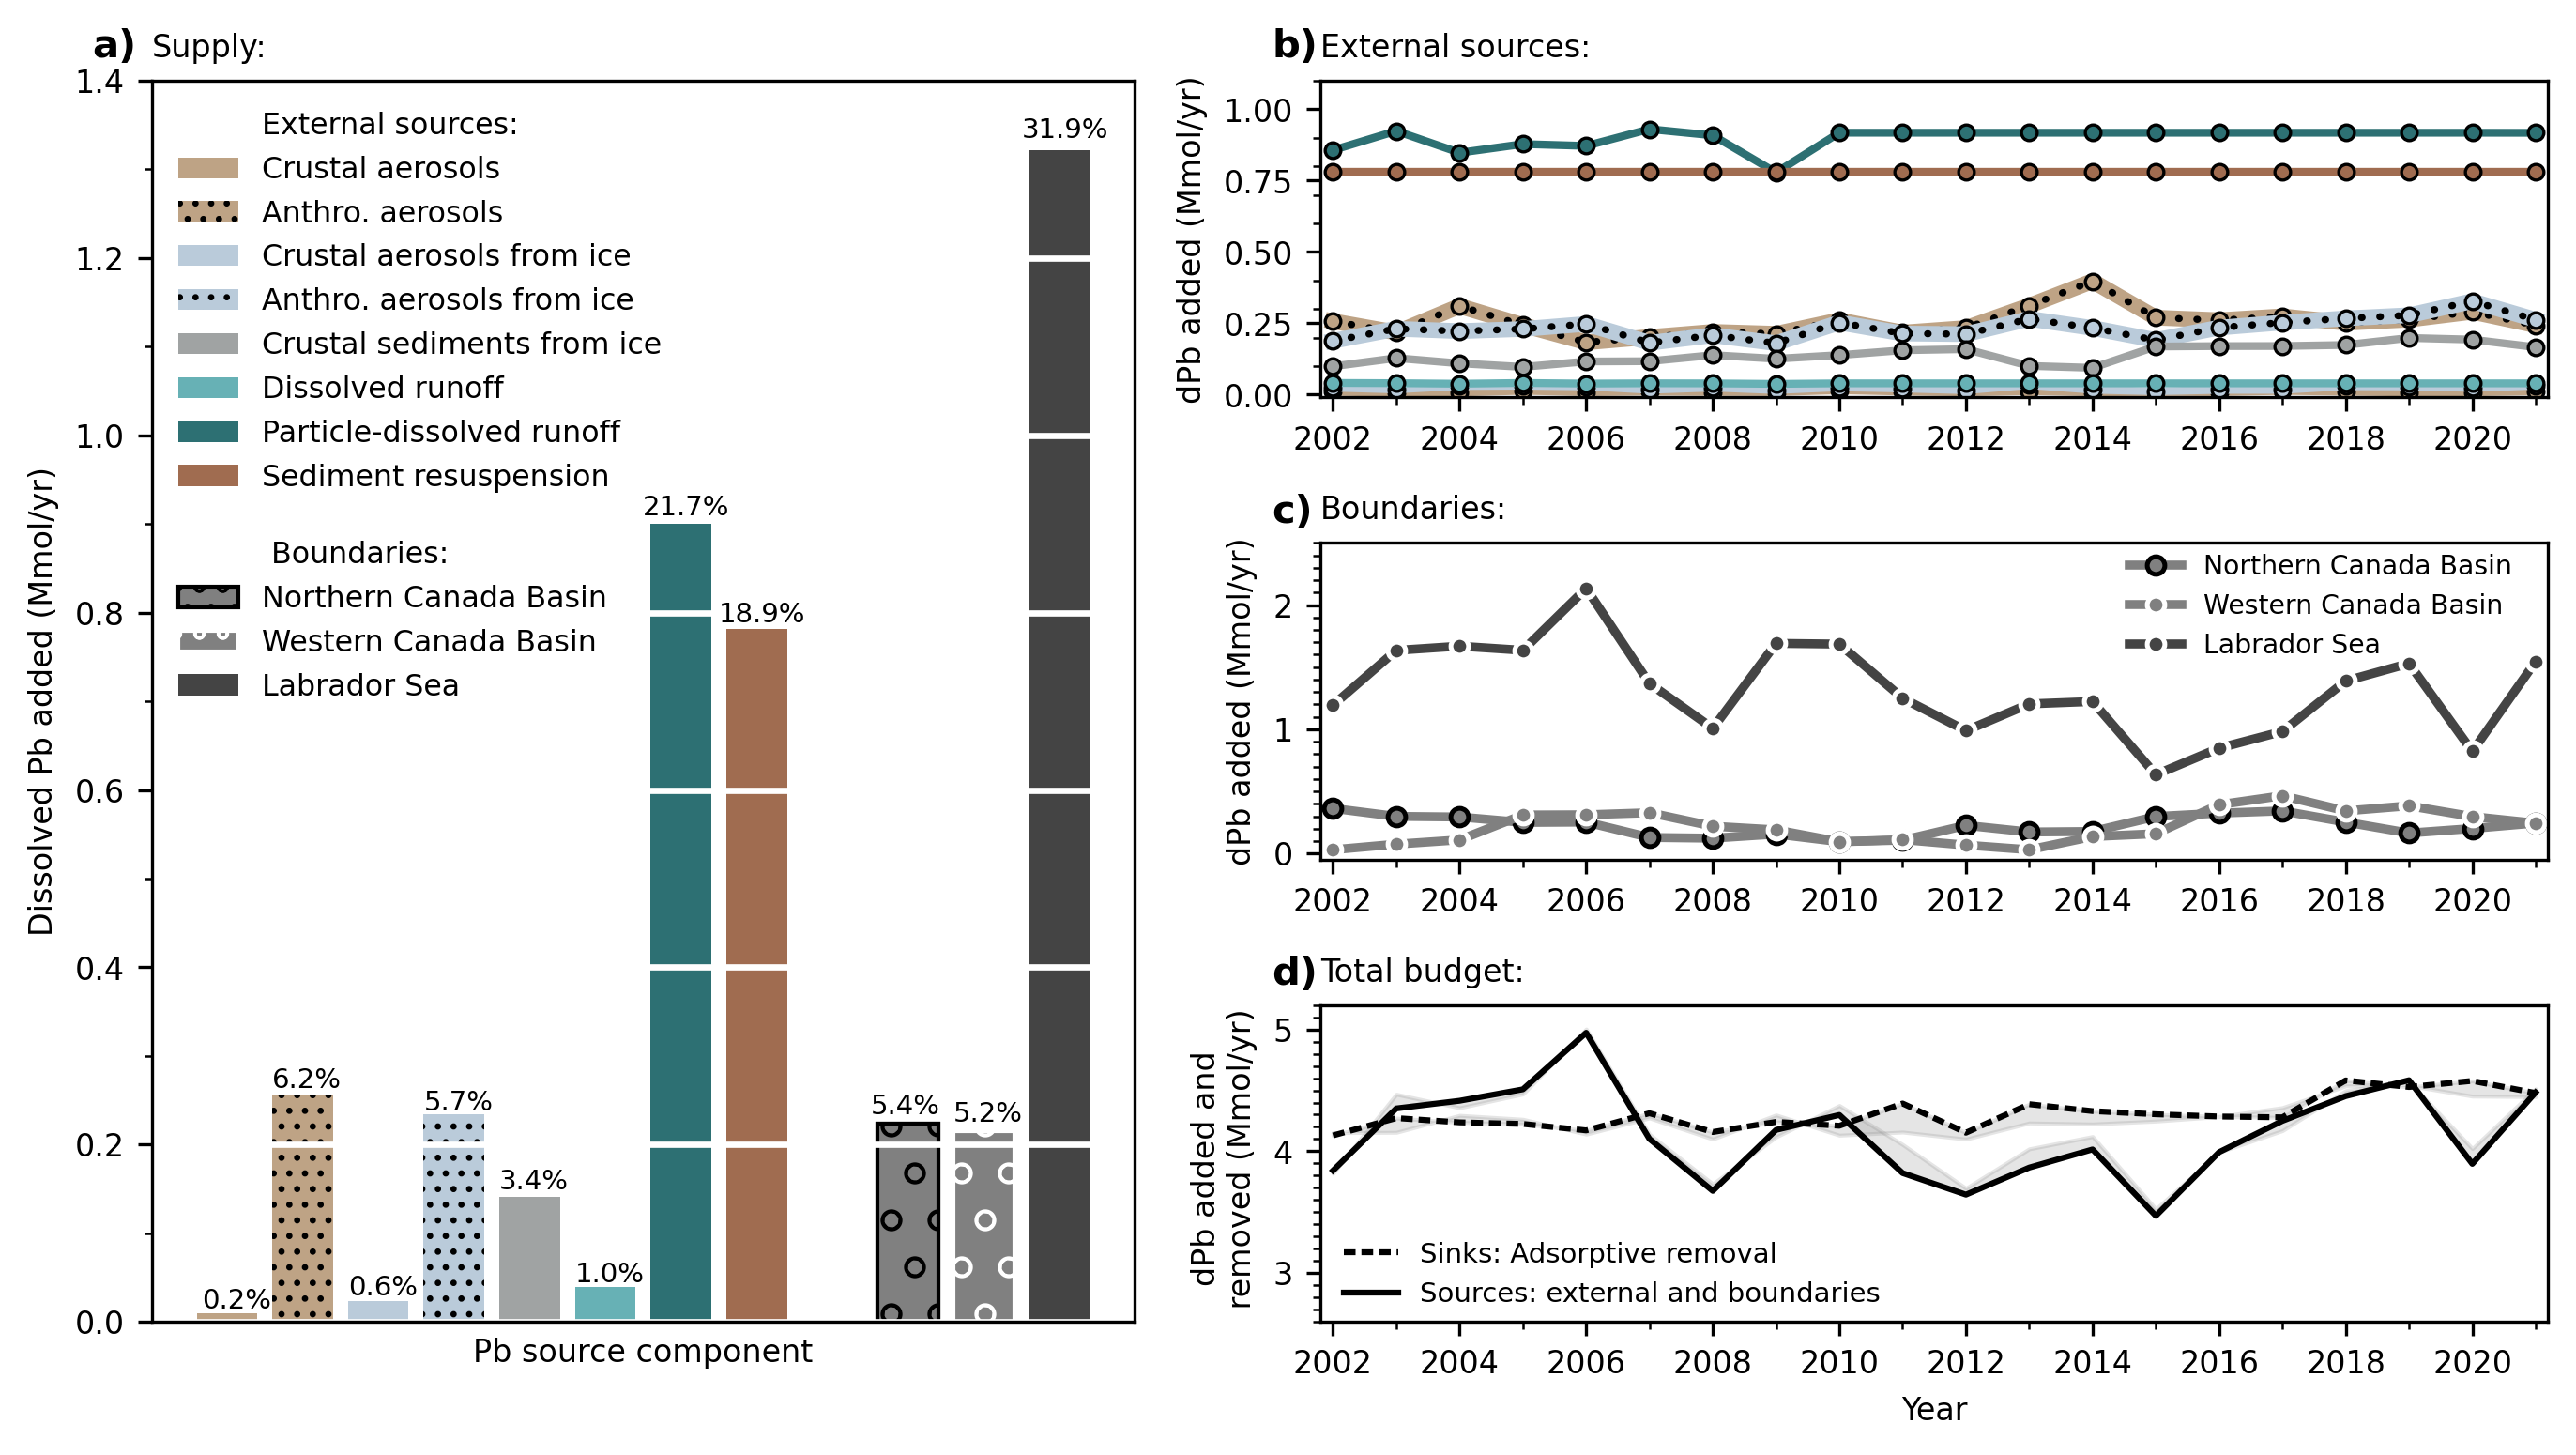

In [38]:
fig = plt.figure(figsize=(4.7*2,3.5*1.5), dpi=300)
gs  = fig.add_gridspec(3,2, width_ratios=[1.6, 2])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])

# Specify locations to print the percentages:
xloc    = [-0.33, 0.6, 1.6, 2.6, 3.6, 4.6, 5.5, 6.5, 7.5, 8.5, 9.6, 10.5]
yloc    = [1.5, 1.03, 1.3, 1.02, 1.06, 1.12, 1.01, 1.01, 1.05, 1.05, 1.05, 1.01]

ax1.plot(0.5,0.5, color='w', label='External sources: ')
for ind, key in enumerate(keys):
    ax1.bar(key, timeseries_total[key].mean()*1e-6, label=labels[ind], width=0.8, color=colors[ind], hatch=patterns[ind])
    ax1.text(xloc[ind], timeseries_total[key].mean()*1e-6*yloc[ind], percent[ind], fontsize=7)
    
    if key=='atm_bc' or key=='ice_bc':
        ax2.plot(years, timeseries_total[key]*1e-6, '-', linewidth=4, color=colors[ind])
        ax2.plot(years, timeseries_total[key]*1e-6, linestyle=(0,(0.1,2.5)), dash_capstyle = 'round',
                  linewidth=1.8, color='k')
        ax2.plot(years, timeseries_total[key]*1e-6, '.', markersize=8, 
                  markeredgecolor='k', markeredgewidth=0.8, color=colors[ind])
    else:
        ax2.plot(years, timeseries_total[key]*1e-6, '.-', markersize=8, linewidth=2.0, 
                  markeredgecolor='k', markeredgewidth=0.8, color=colors[ind])

# Transport via boundaries:
ax1.bar('HB', interannual_HB.mean(), width=0.8, color='w', label='\n Boundaries: ')
ax1.bar('nCB', -interannual_nCB.mean(), width=0.8, color='gray', label='Northern Canada Basin', hatch='oo', edgecolor='k')
ax1.bar('wCB', -interannual_wCB.mean(), width=0.8, color='gray', label='Western Canada Basin', hatch='oo', edgecolor='w')
ax1.bar('nCB', -interannual_nCB.mean(), width=0.8, color='gray', hatch='o', edgecolor='k')
ax1.bar('wCB', -interannual_wCB.mean(), width=0.8, color='gray', hatch='o', edgecolor='w')
ax1.bar('LS', interannual_LS.mean(), width=0.8, color='#444444', label='Labrador Sea')
ax1.text(xloc[8], interannual_HB.mean()*yloc[8], percent[8], fontsize=7)
ax1.text(xloc[9], -interannual_nCB.mean()*yloc[9], percent[9], fontsize=7)
ax1.text(xloc[10], -interannual_wCB.mean()*yloc[10], percent[10], fontsize=7)
ax1.text(xloc[11], interannual_LS.mean()*yloc[11], percent[11], fontsize=7)

# left plot:
ax1.grid(color='white', axis='y', linewidth=1.6)
ax1.set_xlabel('Pb source component', fontsize=8)
ax1.set_ylabel('Dissolved Pb added (Mmol/yr)', fontsize=8)
ax1.legend(loc=(0.015, 0.49), fontsize=7.6, frameon=False)
ax1.set_ylim(0,1.4)
ax1.set_xticks([])
ax1.set_xticklabels([])

# right plots:
ax3.plot(years, -interannual_nCB, linestyle='solid', linewidth=2.3, marker='.',
         markersize=9, markeredgecolor='k', markeredgewidth=1.2, c='gray', label='Northern Canada Basin')
ax3.plot(years, -interannual_wCB, linestyle='solid', linewidth=2.3, marker='.', 
         markersize=9, markeredgecolor='w', markeredgewidth=1.2, c='gray', label='Western Canada Basin')
ax3.plot(years, interannual_LS  , linestyle='solid', linewidth=2.3, marker='.',
         markersize=9, markeredgecolor='w', markeredgewidth=1.2, c='#444444', label='Labrador Sea')
ax3.legend(loc=(0.65, 0.6), fontsize=6.8, frameon=False)

# Total:
# add uncertainty range to background of plot
total_plot = np.array([timeseries_total[key] for key in keys]).sum(axis=0) \
                -interannual_nCB*1e6 -interannual_wCB*1e6 + interannual_LS*1e6 +interannual_HB*1e6
ax4.plot(years, timeseries_total['adsorp']*1e-6, linewidth=1.5, linestyle=(0,(2,1)), color='k', label = 'Sinks: Adsorptive removal')
ax4.plot(years, total_plot*1e-6, linewidth=1.5, color='k', label = 'Sources: external and boundaries')
# fill area between lines:
ax4.fill_between(years, (total_plot*1e-6), (total_plot*1e-6)+error, color='gray', alpha=0.2)
ax4.fill_between(years, (timeseries_total['adsorp']*1e-6)-error, (timeseries_total['adsorp']*1e-6), color='gray', alpha=0.2)
ax4.legend(loc=(0.01, 0.01), fontsize=7, frameon=False)
    
ax4.set_xlabel('Year', fontsize=8)
ax2.set_ylim(-0.01, 1.1)
ax3.set_ylim(-0.05, 2.5)
ax4.set_ylim(2.6, 5.2)
for axis in [ax2, ax3, ax4]:
    axis.set_xlim(2001.8,2021.2)
    axis.xaxis.set_major_locator(MultipleLocator(2))
    axis.xaxis.set_minor_locator(MultipleLocator(1))

for axis in [ax1, ax2, ax3, ax4]:
    axis.tick_params(axis='both', labelsize=8)
    axis.yaxis.set_minor_locator(MultipleLocator(0.1))
    
fig.text(0.040, 0.955, 'a)', fontsize=10, weight='bold');
fig.text(0.486, 0.955, 'b)', fontsize=10, weight='bold');
fig.text(0.486, 0.640, 'c)', fontsize=10, weight='bold');
fig.text(0.486, 0.328, 'd)', fontsize=10, weight='bold');

ax1.set_title('Supply:', fontsize=8, loc='left')    
ax2.set_title('External sources:', fontsize=8, loc='left')    
ax3.set_title('Boundaries:', fontsize=8, loc='left') 
ax4.set_title('Total budget:', fontsize=8, loc='left')       

ax2.set_ylabel('dPb added (Mmol/yr)', fontsize=8)
ax3.set_ylabel('dPb added (Mmol/yr)', fontsize=8)
ax4.set_ylabel('dPb added and \n removed (Mmol/yr)', fontsize=8)
plt.tight_layout(h_pad=1)
fig.savefig(f'{path_figure}R6-budget.jpg', dpi=300, bbox_inches='tight')